In [1]:
import pandas
import numpy as np
import xarray
import matplotlib.pyplot as plt
import ulmo
from ulmo.utils import image_utils
from ulmo.plotting import plotting

/Users/rachelstumpf/ulmo/ulmo/utils/image_utils.py:8: UserWarning: healpy not installed.  Not all functions will work!
  warnings.warn("healpy not installed.  Not all functions will work!")


In [2]:
# read data set from Nautilus files: list of 98% clear locations / dates

df = pandas.read_parquet('/Users/rachelstumpf/Documents/VIIRS_all_98clear_std.parquet')

In [3]:
# read data set from super-collated night + day, 2016-02-06

data_xr = xarray.open_dataset("/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2016/037/20160206120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc")
# xarray.open_dataset, helpful for exploring file, need load_dataset for extractions

In [4]:
# using Nautilus list, find matching date and see what location we should try and extract
# idea is to extract a region we know should have little impact of cloud cover

df['datetime'] = pandas.to_datetime(df['datetime'])

target_date = pandas.to_datetime('2016-02-06')
target_time = pandas.to_datetime('12:00:00')

filtered_df = df[(df['datetime'].dt.date == target_date.date()) & (df['datetime'].dt.time == target_time.time())]

# okay, now we have a matching time and can extract from the xarray data set.
# let's work with the row: latitude -25.600262, longitude 12.210180

filtered_df.iloc[-1]

cutout = filtered_df.loc[1278485] # this selects same row, using the name column
print(cutout)

# cutout.pp_file

filename            s3://viirs/data/2016/037/20160206120000-OSPO-L...
row                                                              4464
col                                                              2784
lat                                                        -25.600262
lon                                                          12.21018
clear_fraction                                               0.002306
field_size                                                        192
datetime                                          2016-02-06 12:00:00
ex_filename         s3://viirs/Extractions/VIIRS_2016_95clear_192x...
pp_file             s3://viirs/PreProc/VIIRS_2016_95clear_192x192_...
pp_root                                                     viirs_std
pp_idx                                                          15394
pp_type                                                             0
mean_temperature                                            22.454268
Tmin                

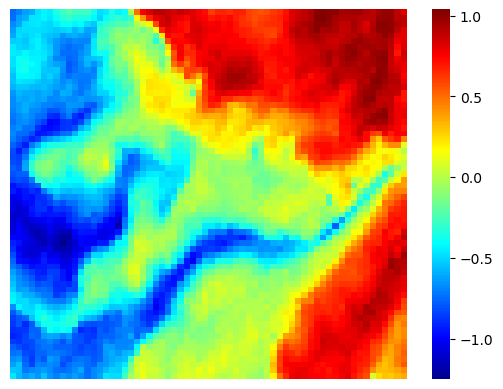

In [5]:
# this will get the image from the PreProc nautilus folder, this is VIIRs data at matching spot to the super-collated set
img = image_utils.grab_image(cutout, local_file = "/Users/rachelstumpf/ulmo/VIIRS_2016_95clear_192x192_preproc_viirs_std.h5")
plot1 = plotting.show_image(img)

In [6]:
# find region of interest in the super-collated data set
# extract region surrounding target area (since we know it should have less than 2% masked)

centered_lat = -25.6
centered_lon = 12.21
pixel_num = 64

variable = data_xr['sea_surface_temperature']

lats = variable['lat'].values
lons = variable['lon'].values

center_lat = np.abs(lats-centered_lat).argmin()
center_lon = np.abs(lons-centered_lon).argmin()

start_lat = center_lat - (pixel_num // 2)
end_lat = start_lat + pixel_num
start_lon = center_lon - (pixel_num // 2)
end_lon = start_lon + pixel_num

subarray = variable.isel(lat = slice(start_lat,end_lat), lon = slice(start_lon,end_lon))

# now check the masking percentage in this subarray

# np.isnan(subarray).mean() # perfect, only 0.00121438!

# np.isnan(subarray).sum()

#subarray.plot()
#plt.show()

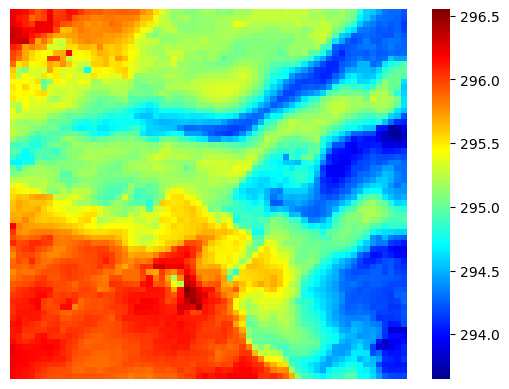

In [7]:
# plot using ulmo function

plot2 = plotting.show_image(subarray.data[0,...])

In [8]:
# across this grid, what is the average sea surface temperature? 

print(subarray.mean())
# the mean temperature is 295.19714, should I be converting this to Celsius? 
# in the Nautilus data set, the temperature for this region should be 22.454, which is 295.604 Kelvin
# I don't know if this subarray is the right pixel dimensions
# so what we want from this is a region that is 64 pixels latitude by 64 pixels longitude, centered on the point chosen
# might need to cut out something bigger and then reduce down to 64x64

<xarray.DataArray 'sea_surface_temperature' ()>
array(295.19714, dtype=float32)


In [9]:
# we want a point centered on lon,lat = 70W,35N on 2020-03-11
# this means we need lon = -70, lat = 35

data_xr2 = xarray.open_dataset("/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2020/071/20200311120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc")
data_xr2

centered_lat = 35
centered_lon = -70
pixel_num = 64

lats = data_xr2['lat'].values
lons = data_xr2['lon'].values

center_lat = np.abs(lats-centered_lat).argmin()
center_lon = np.abs(lons-centered_lon).argmin()

start_lat = center_lat - (pixel_num // 2)
end_lat = start_lat + pixel_num
start_lon = center_lon - (pixel_num // 2)
end_lon = start_lon + pixel_num

subset = data_xr2.isel(lat = slice(start_lat,end_lat), lon = slice(start_lon,end_lon))

In [10]:
np.count_nonzero(np.isnan(subset['sea_surface_temperature'].values))
np.isnan(subset['sea_surface_temperature']).mean()

# there are 4096 pixels, and 3230 in this subset are nan

<xarray.DataArray 'sea_surface_temperature' ()>
array(0.78857422)

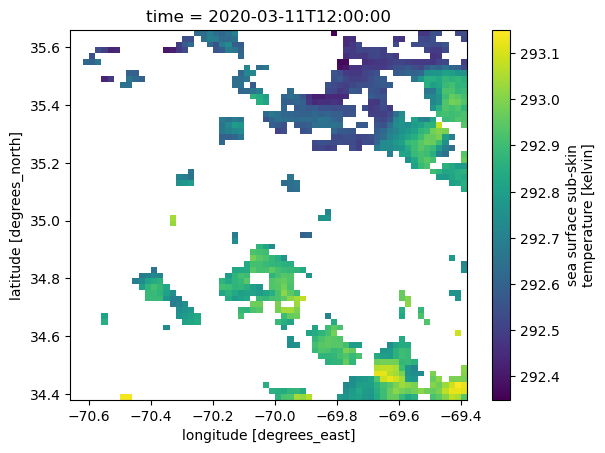

In [11]:
subset['sea_surface_temperature'].plot()
plt.show()